# Clone repository from github

In [7]:
# Load the data on the server session
!git clone https://github.com/RealThanosP/pred-main-mod

# Change your working directory inside the repository
%cd pred-main-mod

Cloning into 'pred-main-mod'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 144 (delta 78), reused 2 (delta 0), pack-reused 28 (from 2)
Receiving objects: 100% (144/144), 95.49 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (29/29), done.
/content/pred-main-mod


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os
import seaborn as sns

#Getting the sensor files in a list

In [ ]:
folder_path = "data/condition+monitoring+of+hydraulic+systems"

# Define the list of sensors and their corresponding column names
sensors = [
    "PS1", "PS2", "PS3", "PS4", "PS5", "PS6",  # Pressure sensors
    "EPS1",  # Motor power
    "FS1", "FS2",  # Volume flow
    "TS1", "TS2", "TS3", "TS4",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

In [ ]:
# Gets all the text files from dataset
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Keeps only the data that have a sensor name in the filename
sensor_file_path_list = [f"{folder_path}/{f}" for f in txt_files if any(sensor in f for sensor in sensors)]
sensor_file_path_list.sort()

#Loading Data

Based on the description the classification for the data is:

The target condition values are cycle-wise annotated in �profile.txt� (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %: 3: close to total failure 20: reduced effifiency 100: full efficiency

2: Valve condition / %: 100: optimal switching behavior 90: small lag 80: severe lag 73: close to total failure

3: Internal pump leakage: 0: no leakage 1: weak leakage 2: severe leakage

4: Hydraulic accumulator / bar: 130: optimal pressure 115: slightly reduced pressure 100: severely reduced pressure 90: close to total failure

5: stable flag: 0: conditions were stable 1: static conditions might not have been reached yet

In [ ]:
# profile
profile = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
profile.columns = ["Cooler condition %", "Valve condition %", "Internal pump leakage", "Hydraulic accumulator / bar", "stable flag"]
profile.insert(0, "Cycle", [i + 1 for i in range(len(profile))]) # Insert Cycle column for easier plotting
profile

,Cycle,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1
...,...,...,...,...,...,...
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0


#Data preperation

In [ ]:
import pandas as pd
import os

# load all the files as seperate DataFrames with the file name as name
for file_path in sensor_file_path_list:
    # remove the .txt
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # read the file and save it with the right name
    globals()[file_name] = pd.read_csv(file_path, sep="\t", header=None)

##Feature engineering

## kurtosis + skewness

Έχουμε κάνει mean, std, min, max απο ότι είδα αλλά είδα πως σημαντικα επισης είναι τα kurtosis, skewness

Source:
https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157098104775&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=733936221287&utm_targetid=aud-517318241987:dsa-2264919291789&utm_loc_interest_ms=&utm_loc_physical_ms=9061571&utm_content=dsa~tofu~tutorial~data-analysis&accountid=9624585688&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-emea_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&gad_source=1&gclid=Cj0KCQjw2N2_BhCAARIsAK4pEkVMsVO3XAsft22sruGNIlwboVIv_fz2Imwmi1PUD_ypp-hwkLD19kUaAsxMEALw_wcB

youtube source (λιγότερο βαρετό) : https://www.youtube.com/watch?v=EWuR4EGc9EY

In [ ]:
# function that does the feature engineering
def create_stats(sensor_name):
    # We get the DataFrame dynamically from the name
    df = globals()[sensor_name]

    # Calculate statistics
    stats = pd.DataFrame({
        'mean'+ sensor_name: df.mean(axis=1),

        'kurtosis'+ sensor_name: df.kurtosis(axis=1),
        'skewness'+ sensor_name: df.skew(axis=1),

        'std'+ sensor_name: df.std(axis=1),
        'min'+ sensor_name: df.min(axis=1),
        'max'+ sensor_name: df.max(axis=1),
        'range'+ sensor_name: df.max(axis=1) - df.min(axis=1),
        'rms'+ sensor_name: (df.pow(2).mean(axis=1)).pow(0.5)
    })

    return stats

In [ ]:
# dictionary to save the names as keys and the dataframes as values
stats_dfs = {}

for sensor in sensors:
    stats_dfs[f'{sensor}_stats'] = create_stats(sensor)

# Converts the keys of the dictionary to variables
globals().update(stats_dfs)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,47.202,47.273,47.250,47.332,47.213,47.372,47.273,47.438,46.691,46.599,...,31.554,30.953,30.639,30.561,30.368,30.224,29.790,29.261,29.287,28.866
1,29.208,28.822,28.805,28.922,28.591,28.643,28.216,27.812,27.514,27.481,...,23.995,24.328,24.283,23.877,23.816,23.933,23.354,23.483,23.320,23.588
2,23.554,23.521,23.527,23.008,23.042,23.052,22.658,22.952,22.908,22.359,...,21.711,21.564,21.564,21.526,21.753,21.749,21.802,21.582,21.283,21.519
3,21.540,21.419,21.565,20.857,21.052,21.039,20.926,20.912,20.989,20.882,...,20.687,20.703,20.295,20.482,20.600,20.547,20.708,20.708,20.574,20.403
4,20.460,20.298,20.350,19.867,19.997,19.972,19.924,19.813,19.691,19.634,...,19.887,19.919,19.696,19.634,19.747,20.005,19.919,19.736,19.977,20.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.798,46.688,46.699,46.844,46.819,46.725,46.713,46.832,46.727,46.362,...,46.375,46.334,46.395,46.264,46.325,46.255,46.375,46.421,46.242,46.382
2201,46.477,46.525,46.013,46.349,46.345,46.286,46.156,46.406,46.188,45.762,...,46.529,46.770,46.649,46.565,46.532,46.521,46.615,46.603,46.710,46.729
2202,46.757,46.863,46.756,46.863,46.816,46.813,46.863,46.863,46.849,46.710,...,45.886,45.715,45.683,45.836,45.943,45.774,46.051,45.800,46.171,46.502
2203,46.584,46.469,46.538,46.538,46.477,46.432,46.491,46.514,46.539,46.432,...,46.640,46.181,46.351,46.723,46.699,46.579,46.687,46.590,46.579,46.570


### Average value of skewness in each sensor

τα γράφω έτσι ώστε να βεβαιωθώ πως βγαίνουν σωστά οι τιμές

In [ ]:
x1= pd.concat([PS1_stats.skewnessPS1, PS2_stats.skewnessPS2, PS3_stats.skewnessPS3, PS4_stats.skewnessPS4, PS5_stats.skewnessPS5, PS6_stats.skewnessPS6], axis=1)
x2 = pd.concat([EPS1_stats.skewnessEPS1], axis=1)
x3 = pd.concat([FS1_stats.skewnessFS1, FS2_stats.skewnessFS2], axis=1)
x4 = pd.concat([TS1_stats.skewnessTS1, TS2_stats.skewnessTS2, TS3_stats.skewnessTS3, TS4_stats.skewnessTS4],axis=1)
x5 = pd.concat([VS1_stats.skewnessVS1],axis=1)
x6 = pd.concat([CE_stats.skewnessCE],axis=1)
x7 = pd.concat([CP_stats.skewnessCP],axis=1)
x8 = pd.concat([SE_stats.skewnessSE],axis=1)

In [ ]:
x1.values.mean() # gia na dw oti ta bgazei swsta

np.float64(0.31423613785246246)

In [ ]:
x2.values.mean()# gia na dw oti ta bgazei swsta

np.float64(1.0856406320899776)

In [ ]:
x_list = [x1, x2, x3, x4, x5, x6, x7, x8]  # Create a list of your DataFrames

for i in range(len(x_list)):
  print(x_list[i].values.mean()) # Access DataFrames from the list and calculate the mean

0.31423613785246246
1.0856406320899776
-0.5085914211338508
-0.19818780541644482
0.7804281054512161
0.19779626098394398
0.3183773371903026
-1.763111048563694


In [ ]:
means = [x.values.mean() for x in x_list]
overall_mean = sum(means) / len(means)
print(overall_mean)

0.028323524806739137


### plot of average value of skewness

τα μπλε ορθογώνια είναι τα χ1-χ8 και η κόκκινη γραμμή, ο μέσος όρος τους

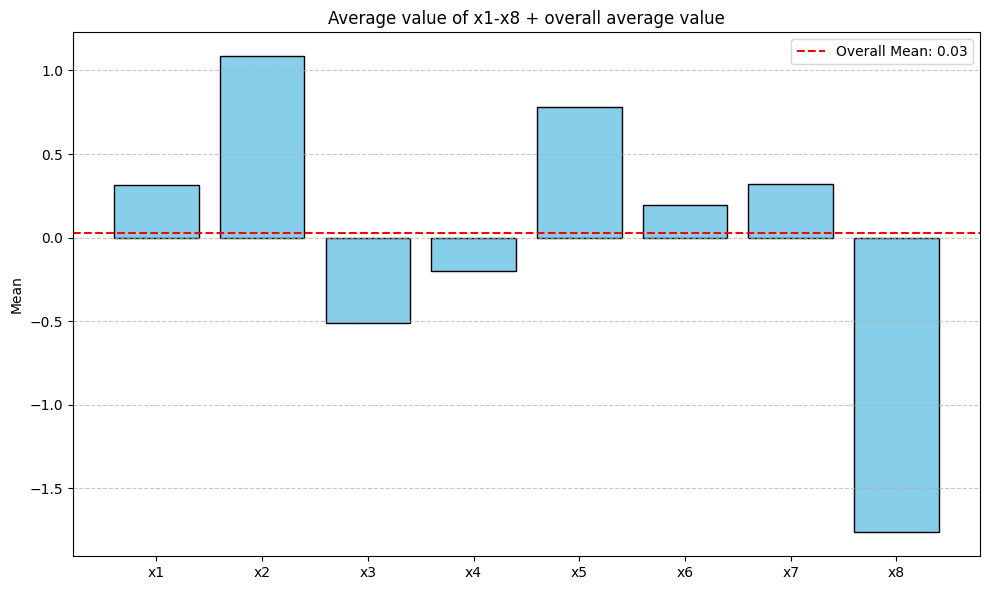

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


means = [x.values.mean() for x in x_list]
overall_mean = np.mean(means)

# Create labels for x-axis
labels = [f'x{i+1}' for i in range(len(x_list))]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, means, color='skyblue', edgecolor='black')
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
plt.title('Average value of x1-x8 + overall average value')
plt.ylabel('Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Average value of kurtosis in each sensor

In [ ]:
y1= pd.concat([PS1_stats.kurtosisPS1, PS2_stats.kurtosisPS2, PS3_stats.kurtosisPS3, PS4_stats.kurtosisPS4, PS5_stats.kurtosisPS5, PS6_stats.kurtosisPS6], axis=1)
y2 = pd.concat([EPS1_stats.kurtosisEPS1], axis=1)
y3 = pd.concat([FS1_stats.kurtosisFS1, FS2_stats.kurtosisFS2], axis=1)
y4 = pd.concat([TS1_stats.kurtosisTS1, TS2_stats.kurtosisTS2, TS3_stats.kurtosisTS3, TS4_stats.kurtosisTS4],axis=1)
y5 = pd.concat([VS1_stats.kurtosisVS1],axis=1)
y6 = pd.concat([CE_stats.kurtosisCE],axis=1)
y7 = pd.concat([CP_stats.kurtosisCP],axis=1)
y8 = pd.concat([SE_stats.kurtosisSE],axis=1)

In [ ]:
y1.values.mean() # gia na dw oti ta bgazei swsta

np.float64(16.94025134016085)

In [ ]:
y2.values.mean() # gia na dw oti ta bgazei swsta

np.float64(0.27057015175599647)

In [ ]:
y_list = [y1, y2, y3, y4, y5, y6, y7, y8]  # akrivws ta idia kanw kai me to skewness

for i in range(len(y_list)):
  print(y_list[i].values.mean())

16.94025134016085
0.27057015175599647
1.0440902887424919
-0.3337980021941852
0.4129463699874921
-0.4767727671921494
-0.468285358169515
2.1612803876326603


In [ ]:
means_y = [y.values.mean() for y in y_list]
overall_mean_y = sum(means_y) / len(means_y)
print(overall_mean_y) # overall kurtosis in the system

2.4437853013404554


### Plot of average value of kurtosis

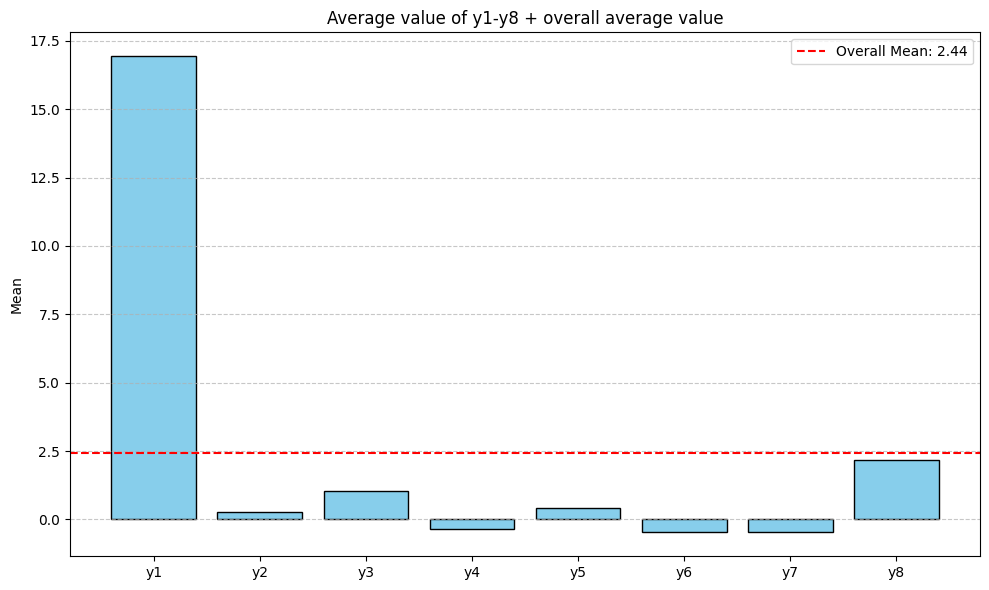

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


means = [y.values.mean() for y in y_list]
overall_mean = np.mean(means)

# Create labels for x-axis
labels = [f'y{i+1}' for i in range(len(y_list))]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, means, color='skyblue', edgecolor='black')
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
plt.title('Average value of y1-y8 + overall average value')
plt.ylabel('Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Trying to define Weights

Θα προσπαθήσω να καθορίσω τα weights στο αρχείο profile.txt για να δουμε ποιο απο τα 4 παίζει μεγαλύτερο ρόλο στο stable flag

Το Logistic regression βγάζει εξηγήσιμα βάρη

Με το SHAP προκύπτουν βάρη που λαμβάνουν υπόψη και αλληλεπιδράσεις

##Defining weights using logistic regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None) #φορτώνω το αρχείο
df.columns = ["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Hydraulic Accumulator", "stable_flag"]

X = df[["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Hydraulic Accumulator"]] #διαχωρίζω τις μεταβλητές
y = df["stable_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #παίρνω το 20% του πίνακα για τεστ και κάνω split τις μεταβλητές

model = LogisticRegression()
model.fit(X_train, y_train)

#Τα αποτελέσματα
#Τα 'βάρη'
print("Weights (coefficients):", model.coef_)
print("Intercept:", model.intercept_)
print("-------------------------------------------\n")

#Πόσο καλό είναι το μοντέλο
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


Weights (coefficients): [[-0.00411867  0.86592211 -2.77244945 -0.01398054]]
Intercept: [-83.35965561]
-------------------------------------------

              precision    recall  f1-score   support

           0       0.98      0.94      0.95       294
           1       0.88      0.95      0.92       147

    accuracy                           0.94       441
   macro avg       0.93      0.94      0.93       441
weighted avg       0.94      0.94      0.94       441



εξηγώ γρήγορα τα weights (τι σημαίνει αρνητικό-θετικό): Θετικό βάρος σημαίνει πως επηρεάζει θετικά στο να είναι stable και αρνητικό επηρεάζει αρνητικά στο να είναι stable

Άρα θέλουμε το internal pump leakage να είναι όσο πιο χαμηλό γίνεται γιατί έχει υψηλό αρνητικό βάρος

Ωστόσο κάποιο άλλο μοντέλο μπορεί να βγάλει άλλα weights γιατί τα ερμηνέυει αλλιώς

In [ ]:
model.score(X_test , y_test)

0.9410430839002267

Το μοντέλο έχει 0.94 score (το έτρεξα βασιζόμενος μόνο στις τιμές του profile.txt)

##Heatmap

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
shap.initjs()

df = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
df.columns = ["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Hydraulic Accumulator", "stable_flag"]


Correlation matri: δείχνει πως συσχετίζονται οι μεταβλητές μεταξύ τους και όχι με το stable flag

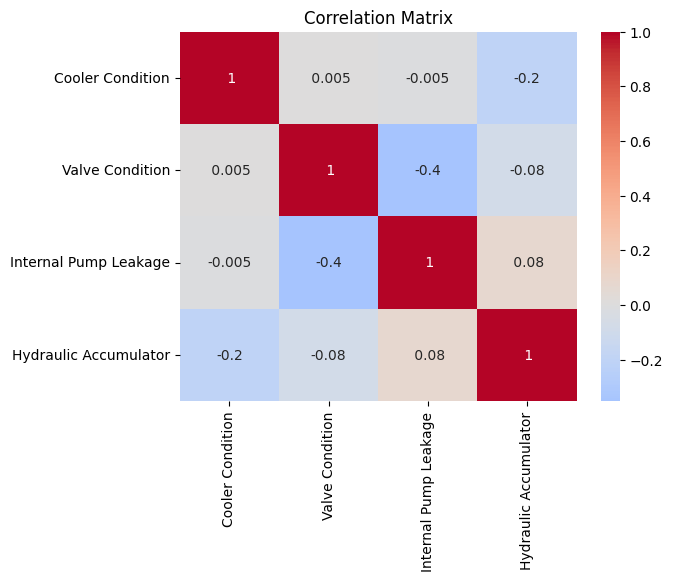

In [9]:
cont = ["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Hydraulic Accumulator"]

correlation_matrix = pd.DataFrame(df[cont],columns=cont).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',center=0,fmt=' .1g')
plt.title('Correlation Matrix')
plt.show()

##Boxplots

Το Boxplots δείχνει αν υπάρχουν διακριτές τιμές στις κατανομές

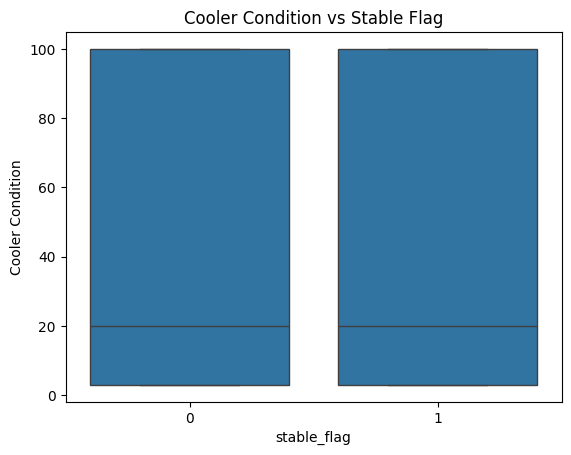

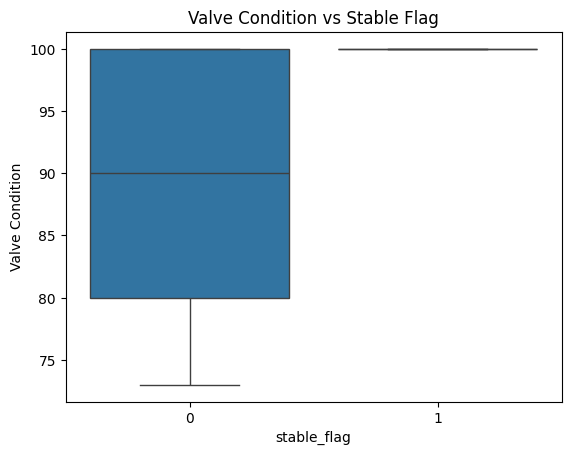

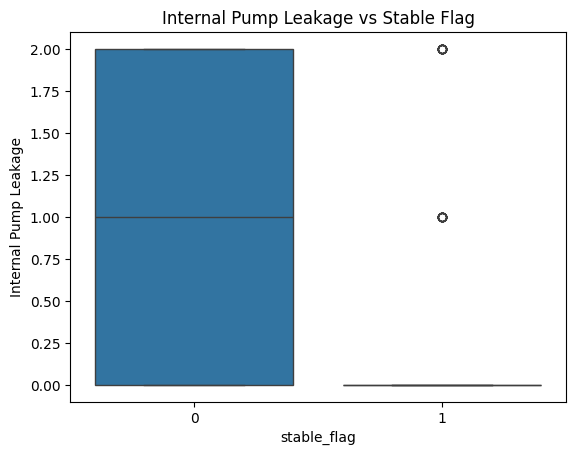

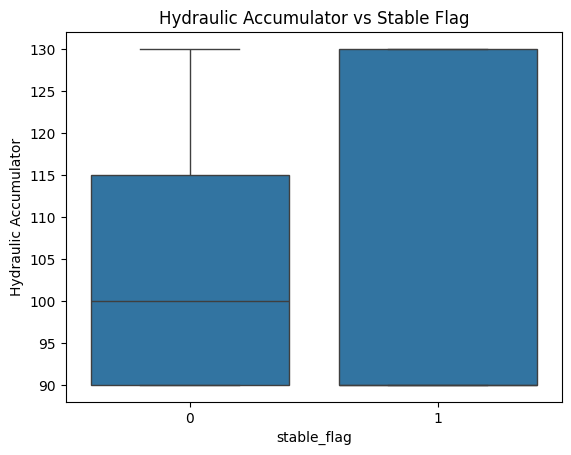

In [23]:
features = ['Cooler Condition', 'Valve Condition', 'Internal Pump Leakage', 'Hydraulic Accumulator']

for feature in features:
    sns.boxplot(data=df, x='stable_flag', y=feature)
    plt.title(f'{feature} vs Stable Flag')
    plt.show()


##Mutual information

To mutual information δείχνει πόσο χρήσιμο είναι το κάθε feature για το classification

In [24]:
from sklearn.feature_selection import mutual_info_classif

X = df[features]
y = df['stable_flag']

mi = mutual_info_classif(X, y, discrete_features=False)
mi_series = pd.Series(mi, index=features).sort_values(ascending=False)
print(mi_series)


Valve Condition          0.319098
Internal Pump Leakage    0.223565
Hydraulic Accumulator    0.102740
Cooler Condition         0.000000
dtype: float64


##Random Forest

Το random forest δείχνει την πρακτική σημασία σε supervised learning ==> πιθανότατα και το πιο σημαντικό για εμάς

Valve Condition          0.548909
Internal Pump Leakage    0.317429
Hydraulic Accumulator    0.088750
Cooler Condition         0.044912
dtype: float64


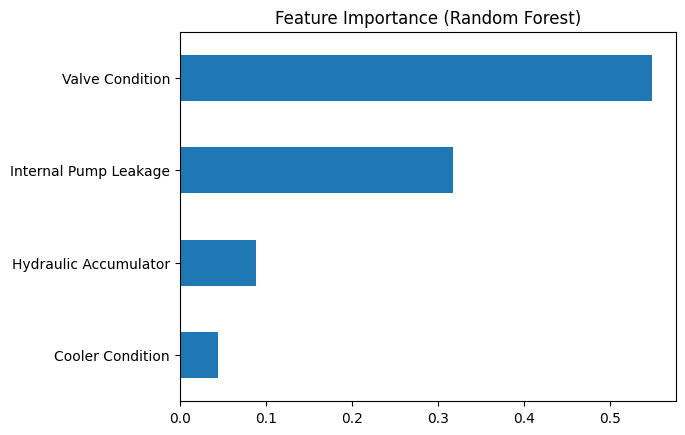

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print(importances)

# Προαιρετικά: plot
importances.plot(kind='barh', title='Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()


##Defining weights using Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None) #φορτώνω το αρχείο
df.columns = ["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Hydraulic Accumulator", "stable_flag"]

X = df[["Cooler Condition", "Valve Condition", "Internal Pump Leakage", "Hydraulic Accumulator"]] #διαχωρίζω τις μεταβλητές
y = df["stable_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #παίρνω το 20% του πίνακα για τεστ και κάνω split τις μεταβλητές

model = LinearRegression()
model.fit(X_train, y_train)

importance = model.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.00021
Feature: 1, Score: 0.02202
Feature: 2, Score: -0.22158
Feature: 3, Score: -0.00150


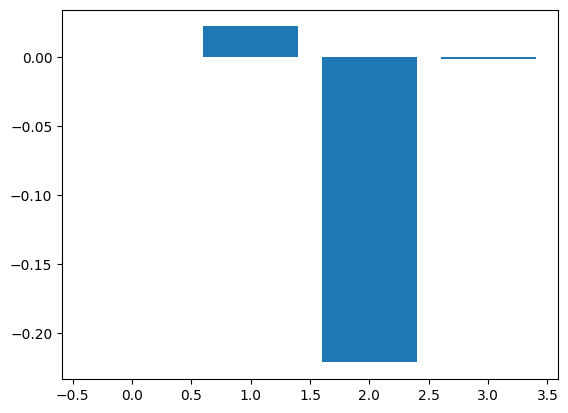

In [21]:
pyplot.bar ([x for x in range (len(importance))], importance)
pyplot.show()